# Regressão logística

Vamos agora considerar o problema de *classificar* um conjunto de pessoas em adolescente ou adulto dependendo da altura.

### Leitura dos dados

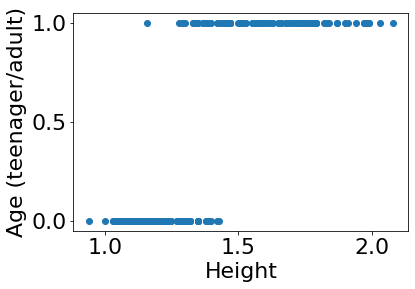

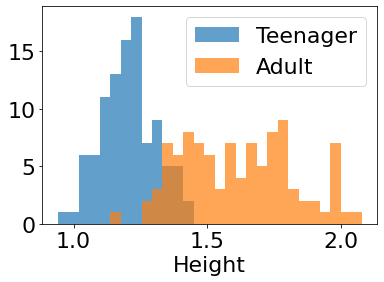

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch

data = torch.from_numpy(np.loadtxt('../data/age_data_3.txt'))
inputs, targets = data.T

plt.scatter(inputs, targets)
plt.xlabel('Height')
plt.ylabel('Age (teenager/adult)')

bins = np.linspace(inputs.min(), inputs.max(), 30)
plt.figure()
plt.hist(inputs[targets==0], bins, alpha=0.7)
plt.hist(inputs[targets==1], bins, alpha=0.7)
plt.xlabel('Height')
plt.legend(('Teenager', 'Adult'))

# Função Sigmóide na Regressão Logística

Na regressão logística, a função sigmóide (ou função logística) é usada para transformar os valores de saída linear do modelo em probabilidades. Essa transformação é essencial para modelar a probabilidade de uma variável dependente binária.

## Função Sigmóide
A função sigmóide é definida como:

$$
 \sigma(x) = \frac{1}{1 + e^{-x}} 
$$

onde $x$ é o valor de entrada, e $e$ é a base dos logaritmos naturais. A função sigmóide mapeia qualquer número real $x$ para o intervalo $(0, 1)$, tornando-a adequada para representar probabilidades.

## Aplicação na Regressão Logística
No modelo de regressão logística, usamos uma combinação linear das variáveis independentes (preditoras) para calcular $x$:

$$
 x = \beta_0 + \beta_1x_1 + \cdots + \beta_nx_n 
$$

onde $\beta_0$ é o intercepto, e $\beta_1, \ldots, \beta_n$ são os coeficientes dos preditores $x_1, \ldots, x_n$.

Em seguida, aplicamos a função sigmóide a $x$ para obter a probabilidade estimada de que a variável dependente seja igual a 1:

$$
 p(y=1) = \sigma(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + \cdots + \beta_nx_n)}} 
$$

## Interpretação das Probabilidades
A saída da função sigmóide, $p(y=1)$, é interpretada como a probabilidade de a variável dependente ser igual a 1, dado os valores das variáveis independentes. Por exemplo, em um modelo de regressão logística que prevê a probabilidade de aprovação em um exame, se $p(y=1) = 0,8$ para um determinado aluno, isso indica que há 80% de probabilidade de o aluno ser aprovado.

Text(0, 0.5, 'P(Adult|Height)')

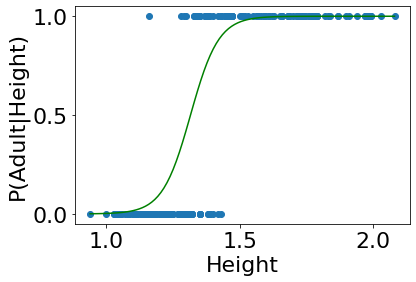

In [31]:
class Model:
    def __init__(self, a, b, requires_grad=False):
        # Parâmetros do modelo
        self.a = torch.tensor(a, requires_grad=requires_grad)
        self.b = torch.tensor(b, requires_grad=requires_grad)

    def __call__(self, x):
        y = self.a*x + self.b
        return  y
    
    def parameters(self):
        return self.a, self.b
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = None
    
def sigmoid(x):
    y = 1/(1+torch.exp(-x))
    return y

model = Model(19., -25.)
scores = model(inputs)
# Probabilidade de cada pessoa ser adulta
probs = sigmoid(scores)

# Cálculo das probabilidades para todas as possíveis entradas x
inputsm = torch.linspace(inputs.min(), inputs.max(), 100)
scoresm = model(inputsm)
probsm = sigmoid(scoresm)

plt.scatter(inputs, targets)
plt.plot(inputsm, probsm, c='g')
plt.xlabel('Height')
plt.ylabel('P(Adult|Height)')

Ao rotularmos os dados como classe 0 e 1, estamos dizendo que temos 100% de certeza que esses dados estão nessas classes. Portanto, na ausência de qualquer outra informação sobre os dados, o melhor modelo que podemos desenvolver para o conjunto de treinamento é tal que:

* Quando o item é da classe 0, o modelo tem como resultado P(Adult|Height)=0.0
* Quando o item é da classe 1, o modelo tem como resultado P(Adult|Height)=1.0

In [32]:
#Acurácia do modelo
def acc(preds, targets):
    return torch.sum(preds==targets)/len(targets)

preds = probs>0.5
acc(preds, targets)

tensor(0.9000)

### Função de verossimilhança

Para um conjunto de dados com $n$ observações, onde cada observação $i$ tem uma variável dependente binária $y_i$ (com valor 0 ou 1) e um vetor de variáveis independentes $x_i$, a função de verossimilhança para a regressão logística é dada por:

$$ L(\beta) = \prod_{i=1}^{n} p_i^{y_i} (1 - p_i)^{1 - y_i} $$

onde:
- $L(\beta)$ é a verossimilhança dos parâmetros $\beta$ (coeficientes do modelo),
- $p_i$ é a probabilidade estimada de $y_i = 1$ dada por $p_i = \frac{1}{1 + e^{-\beta^T x_i}}$ (função sigmóide),
- $y_i$ é o valor real da variável dependente para a observação $i$.

A função de verossimilhança na regressão logística é uma ferramenta essencial para entender como os parâmetros do modelo ($(\beta)$) se ajustam aos dados observados ($(y_i)$, $(x_i)$). Ela avalia a probabilidade de se observar os dados atuais dado um conjunto de parâmetros. Vamos detalhar mais sobre seu funcionamento, especialmente como ela recompensa acertos e penaliza erros do modelo, além de como ela explica a adequação das probabilidades estimadas pelo modelo aos dados observados.

### Funcionamento e Implicações da Função de Verossimilhança

#### **Bonificação por Acertos**
A função de verossimilhança $(L(\beta))$ é o produto das probabilidades estimadas para cada observação individual. Para uma observação onde $(y_i = 1)$, a contribuição dessa observação para a verossimilhança é $(p_i)$, a probabilidade estimada de $(y_i = 1)$. Quando o modelo prevê corretamente com alta confiança (ou seja, $(p_i)$ é próximo de 1 para $(y_i = 1)$), o valor de $(p_i^{y_i})$ será também próximo de 1, aumentando a verossimilhança total.

#### **Penalização por Erros**
Da mesma forma, para observações onde $(y_i = 0)$, a contribuição para a verossimilhança é $((1 - p_i))$, que é a probabilidade estimada de $(y_i = 0)$. Se o modelo prediz erroneamente uma alta probabilidade de $(y_i = 1)$ (ou seja, $(p_i)$ é alto quando $(y_i = 0)$), então $((1 - p_i))$ será pequeno, penalizando a verossimilhança total. Essa penalização é drástica especialmente se o modelo está muito confiante na previsão errada, fazendo com que a verossimilhança tenda a zero.

In [33]:
def prob_of_target(probs, targets):
    '''Retorna as probabilidades da classe esperada'''
    return probs*targets + (1-probs)*(1-targets)

""" Equivalente a função acima
def prob_of_target(probs, targets):
    n = len(probs)
    probs_target = torch.zeros(n)
    for idx in range(n):
        prob, target = probs[idx], targets[idx]
        if target==0:
            probs_target[idx] = 1 - prob
        else:
            probs_target[idx] = prob 
"""

def likelihood(probs, targets):
    '''Função de verossimilhança.'''
    probs_correct = prob_of_target(probs, targets)
    return -torch.prod(probs_correct)

print(likelihood(probs, targets))

tensor(-2.2591e-20, dtype=torch.float64)


### Log-Verossimilhança

A log-verossimilhança transforma a multiplicação de probabilidades em uma soma de logaritmos, o que é computacionalmente mais estável e fácil de maximizar usando métodos numéricos. A expressão

$$
 \log L(\beta) = \sum_{i=1}^{n} [y_i \log(p_i) + (1 - y_i) \log(1 - p_i)] 
 $$

representa a soma ponderada dos logaritmos das probabilidades previstas, onde os pesos são os valores reais $(y_i)$ e $(1 - y_i)$. Cada termo da soma reflete como bem a probabilidade prevista se alinha com o valor real:

- **Termo $(y_i \log(p_i))$**: Este termo é significativo quando $(y_i = 1)$. Se o modelo estima corretamente $(p_i)$ como alto, $(\log(p_i))$ é pequeno negativamente (menos negativo), resultando em uma grande contribuição positiva para a log-verossimilhança.
- **Termo $((1 - y_i) \log(1 - p_i))$**: Este termo é crítico quando $(y_i = 0)$. Um $(p_i)$ corretamente baixo leva a $((1 - p_i))$ alto, e $(\log(1 - p_i))$ sendo menos negativo, contribuindo positivamente para a log-verossimilhança.

### Explicando a Adequação do Modelo aos Dados

A log-verossimilhança quantifica como as probabilidades modeladas se alinham com os resultados observados. Um valor alto de log-verossimilhança indica que o modelo é capaz de estimar probabilidades que concordam fortemente com os resultados reais, mostrando uma boa adequação. Maximizar a log-verossimilhança (ou minimizar o negativo da log-verossimilhança, frequentemente chamado de log-loss) durante o treinamento ajusta os parâmetros $(\beta)$ para alinhar as previsões do modelo com os dados observados de maneira ótima.

Em resumo, a função de verossimilhança e sua forma logarítmica são fundamentais na modelagem estatística, pois fornecem um meio quantitativo para avaliar, ajustar e validar a precisão das previsões de um modelo em face dos dados reais.

In [34]:
def nll(probs, targets):
    '''Negativo do logaritmo da função de verossimilhança'''
    probs_correct = prob_of_target(probs, targets)
    probs_log = torch.log(probs_correct)
    return -torch.sum(probs_log)

nll(probs, targets)

tensor(45.2367, dtype=torch.float64)

### Definição da Entropia Cruzada

A entropia cruzada mede a diferença entre duas distribuições de probabilidade: a distribuição verdadeira $( p )$ (verdadeira distribuição dos dados) e a distribuição estimada $( q )$ (predições do modelo). Para tarefas de classificação, a entropia cruzada pode ser definida como:

$$
 H(p, q) = -\sum_{i=1}^{n} p_i \log(q_i) 
$$

onde $( n )$ é o número de classes, $( p_i )$ é a probabilidade real da classe $( i )$ (geralmente 0 ou 1 em classificação de rótulo único), e $( q_i )$ é a probabilidade prevista de $( i )$ fornecida pelo modelo.

In [35]:
def cross_entropy(scores, targets):
    
    probs = sigmoid(scores)
    probs_correct = prob_of_target(probs, targets)
    probs_log = torch.log(probs_correct)

    return -torch.mean(probs_log) # Usa-se a média, ao invés do somatório, para controlar o valor final

cross_entropy(scores, targets)

tensor(0.2262, dtype=torch.float64)

### Implementação e Otimização

Em redes neurais, especialmente ao lidar com múltiplas classes, $( q_i )$ é tipicamente derivado da última camada da rede usando uma função softmax, que transforma os logits (valores de entrada para softmax) em probabilidades que somam 1. O objetivo do treinamento é ajustar os parâmetros do modelo (pesos) para minimizar a entropia cruzada entre as distribuições $( p )$ e $( q )$.

A atualização dos parâmetros pode ser expressa pela regra de atualização em gradiente descendente:

$$
 \beta_j \leftarrow \beta_j - \alpha \frac{\partial}{\partial \beta_j} H(p, q) 
$$

onde $( \alpha )$ é a taxa de aprendizado, e $( \frac{\partial}{\partial \beta_j} H(p, q) )$ é o gradiente da entropia cruzada em relação ao parâmetro $( \beta_j )$.

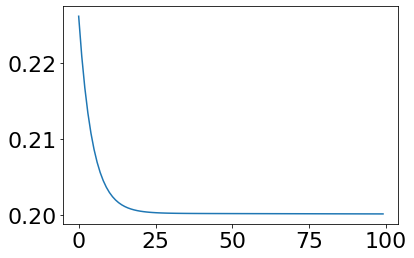

In [36]:
def step(model, x, targets, lr):

    # Apaga os gradientes
    model.zero_grad()
    scores = model(x)
    loss = cross_entropy(scores, targets)
    # Calcula os gradientes
    loss.backward()
    # Atualiza os gradientes
    with torch.no_grad():
        for p in model.parameters():
            p -= lr*p.grad

    return loss.item()

model = Model(19., -25., requires_grad=True)

num_epochs = 100
lr = 0.5
losses = []
for epoch in range(0, num_epochs):
    loss = step(model, inputs, targets, lr)
    losses.append(loss)

plt.plot(losses)

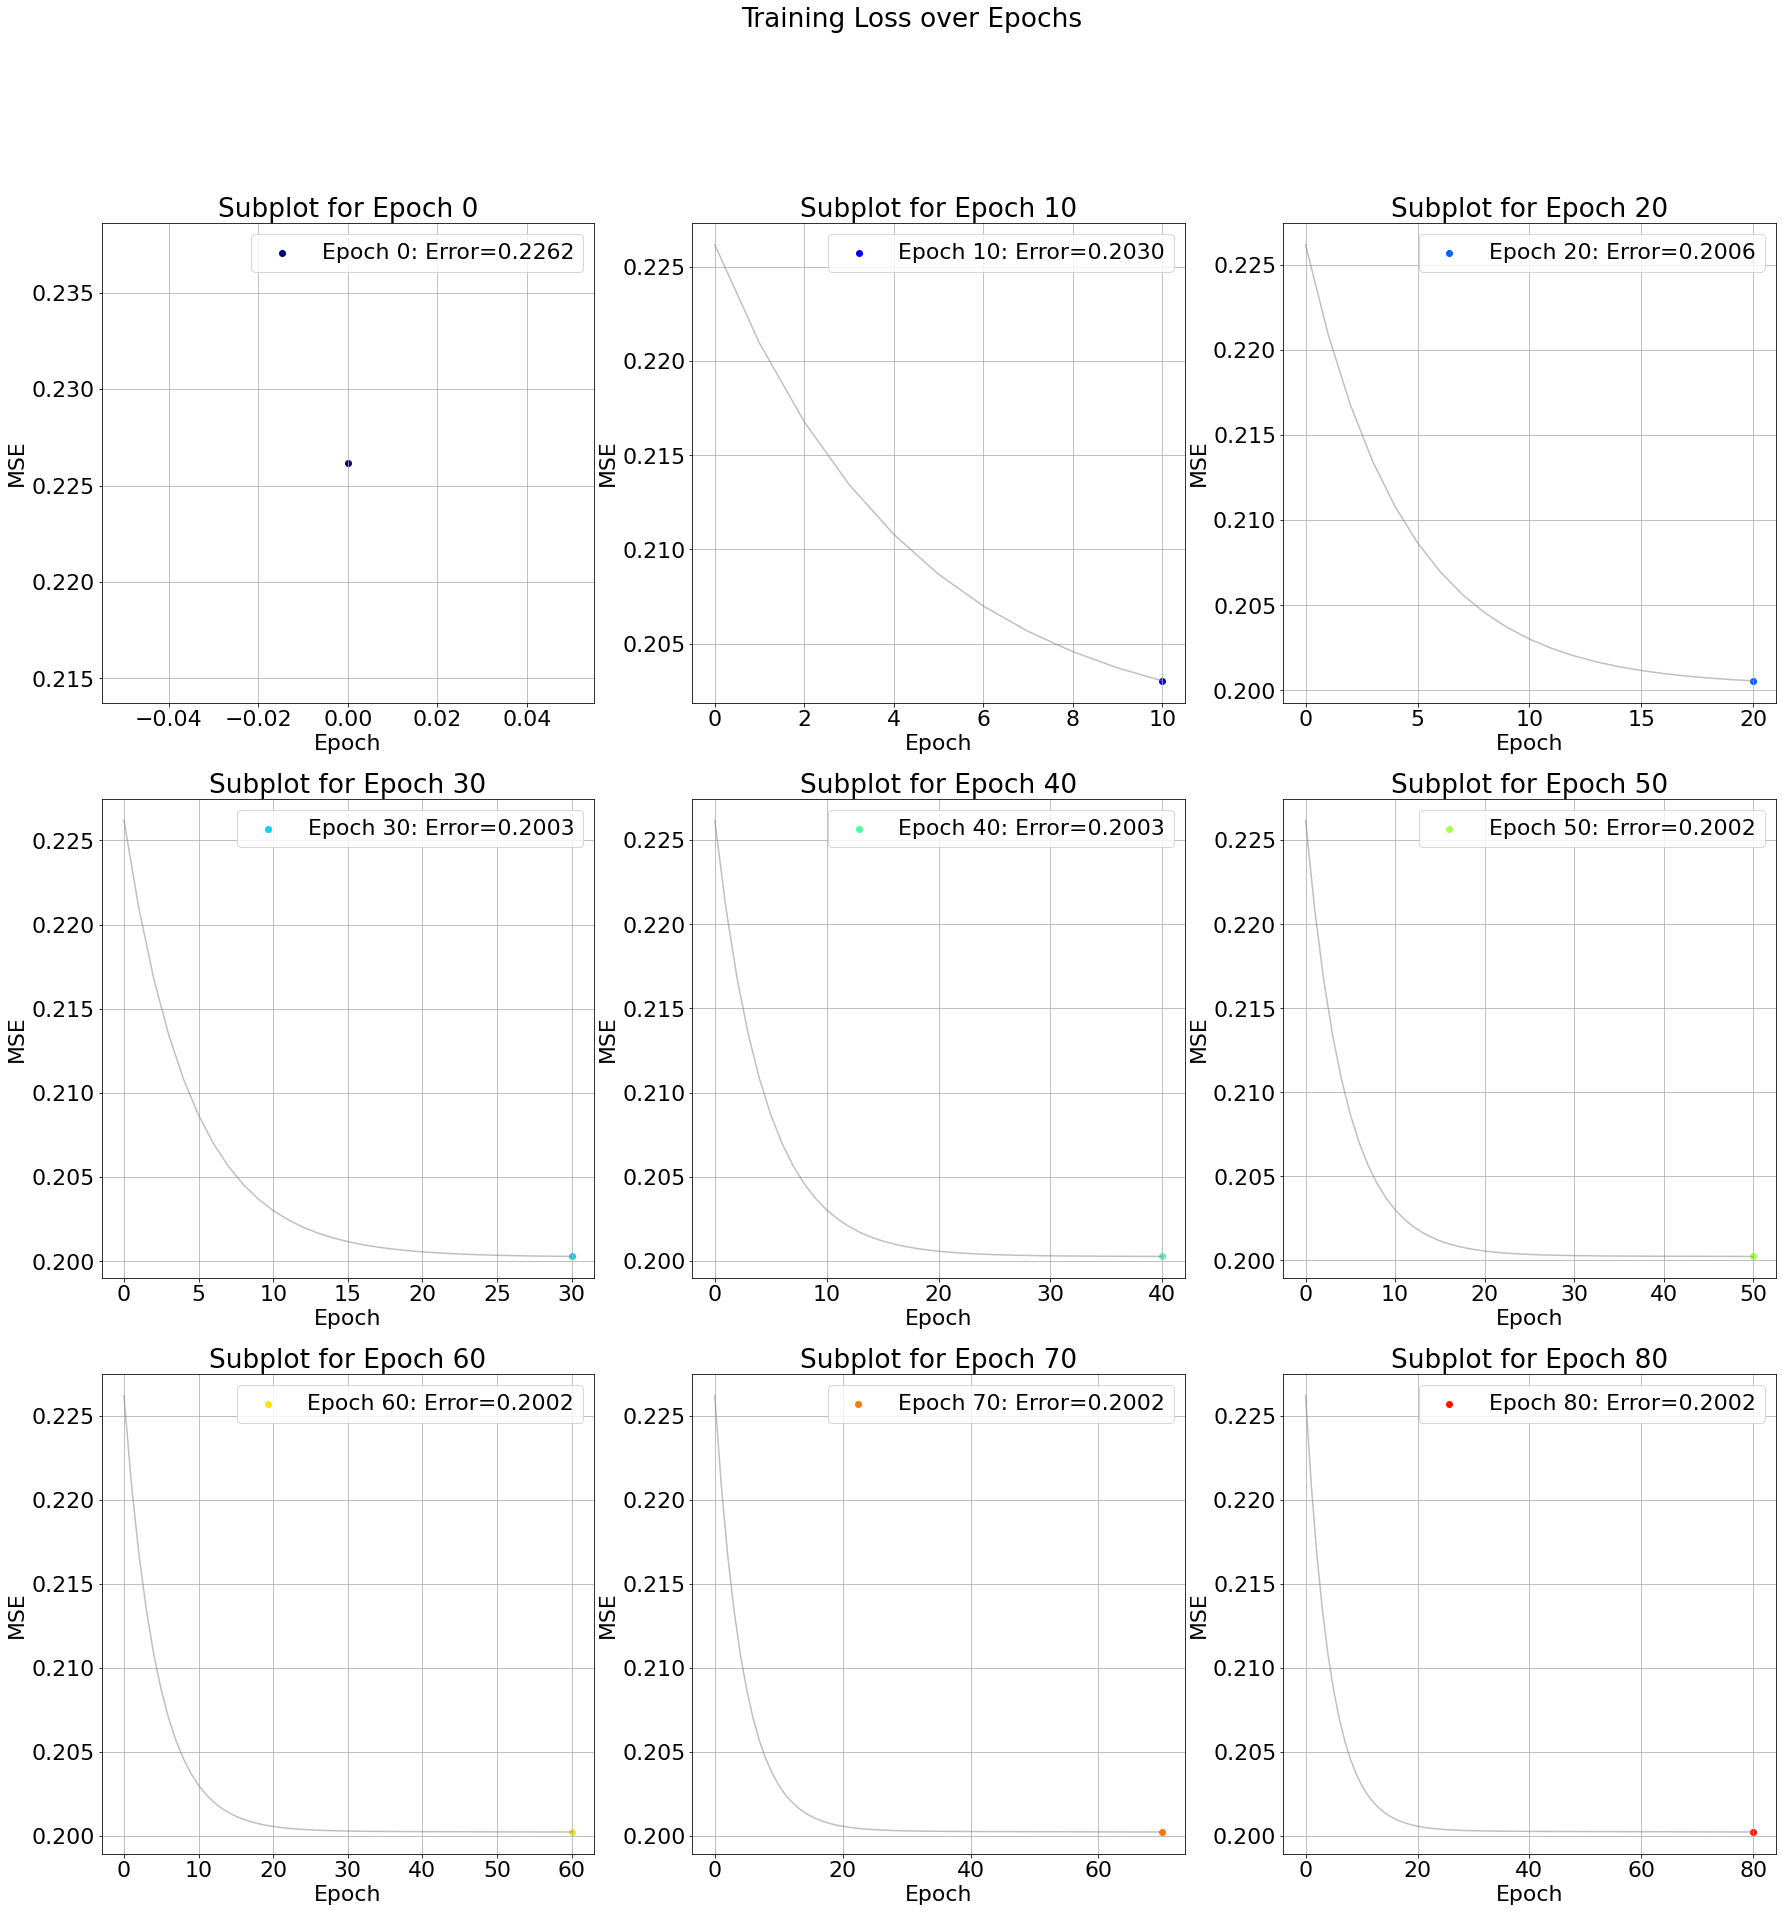

In [39]:
def step(model, x, targets, lr):

    # Apaga os gradientes
    model.zero_grad()
    scores = model(x)
    loss = cross_entropy(scores, targets)
    # Calcula os gradientes
    loss.backward()
    # Atualiza os gradientes
    with torch.no_grad():
        for p in model.parameters():
            p -= lr*p.grad

    return loss.item()

model = Model(19., -25., requires_grad=True)

num_epochs = 100
lr = 0.5
losses = []
plt.rcParams.update({'font.size': 22})  
fig, axes = plt.subplots(3, 3, figsize=(30, 30))
fig.suptitle('Training Loss over Epochs')  

axes_list = [ax for sublist in axes for ax in sublist]
colors = plt.cm.jet(np.linspace(0, 1, 10)) 
update_interval = num_epochs // 10

for epoch in range(num_epochs):
    error = step(model, inputs, targets, lr)
    losses.append(error)
    
    if epoch % update_interval == 0 and epoch // update_interval < 9:
        ax_idx = epoch // update_interval
        ax = axes_list[ax_idx]
        color_idx = epoch // 10 % 10  
        ax.scatter(epoch, error, color=colors[color_idx], label=f'Epoch {epoch}: Error={error:.4f}', marker='o')
        ax.plot(losses, linestyle='-', color='grey', alpha=0.5)  
        ax.set_title(f'Subplot for Epoch {epoch}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')
        ax.legend()  
        ax.grid(True)

plt.show()

### No PyTorch

No PyTorch, a entropia cruzada é comumente utilizada através da função `torch.nn.CrossEntropyLoss`, que combina a operação softmax e a computação da entropia cruzada numa única classe:

- **Entrada para `CrossEntropyLoss`**: Ao contrário de outras implementações que aceitam probabilidades, o PyTorch requer os logits (saídas do modelo antes da softmax) como entrada para `CrossEntropyLoss`. Isto melhora a estabilidade numérica da operação.
- **Média vs. Soma**: A função geralmente retorna a média das perdas calculadas em cada exemplo do lote de entrada, ao invés da soma total. Isso faz a função de perda menos dependente do tamanho do lote.

### Implicações

- **Acurácia do Modelo**: A entropia cruzada é eficaz porque amplifica a penalidade não apenas quando a classificação está errada, mas também quando o modelo está inseguro ou confiante de forma errônea sobre suas previsões erradas.
- **Convergência Rápida**: A utilização da entropia cruzada frequentemente resulta em uma convergência mais rápida durante o treinamento, pois o gradiente tende a ser grande quando a previsão está errada, acelerando assim o aprendizado.

Essa abordagem de usar entropia cruzada como função de perda ajuda a garantir que o modelo não só classifique corretamente, mas também com alta confiança, reduzindo a discrepância entre as distribuições de probabilidade verdadeira e prevista.